Import required files

In [ ]:
%tensorflow_version 2.x
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
START = "startseq"
STOP = "endseq"
EPOCHS = 10


A function that returns formatted time 

In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Download and unzip data

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip glove.6B.zip
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430

List of all the files

In [ ]:
!ls 

CrowdFlowerAnnotations.txt  Flickr_8k.testImages.txt   glove.6B.300d.txt
ExpertAnnotations.txt	    Flickr8k_text.zip	       glove.6B.50d.txt
Flicker8k_Dataset	    Flickr8k.token.txt	       glove.6B.zip
Flickr8k_Dataset.zip	    Flickr_8k.trainImages.txt  __MACOSX
Flickr_8k.devImages.txt     glove.6B.100d.txt	       readme.txt
Flickr8k.lemma.token.txt    glove.6B.200d.txt	       sample_data


Cleaning caption
null_puct maps all the punctuations to None
for each description
1. change the case of words to lowercase
2. convert punctuations to None
3. remove all the words with length less than 2
4. remove all the characters that are not alphabets

make a lookup table (image_id , caption)
and a dictionary lex of all the words



In [ ]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( ('Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]


In [ ]:
print(len(lookup)) # lookup table
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)


8092
8763
32


get the location of all the images

In [ ]:
img = glob.glob(os.path.join('Flicker8k_Dataset', '*.jpg'))

In [ ]:
len(img)

8091

Train/Test split

In [ ]:
train_images_path = 'Flickr_8k.trainImages.txt'
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = 'Flickr_8k.testImages.txt' 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

Display the size of the train and test sets.

In [ ]:
print(len(train_images))
print(len(test_images))

6000
1000


Add start and stop token in captions

In [ ]:

train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [ ]:
type(train_descriptions)

dict

Download inceptionV3 and define image encoder

In [ ]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

96116736/96112376 [==============================] - 3s 0us/step


In [ ]:
encode_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Image encoding function

In [ ]:
def encodeImage(img):
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = encode_model.predict(x) 
  x = np.reshape(x, OUTPUT_DIM )
  return x

Encode all train images and store them to pickle file

In [ ]:
train_path = os.path.join(f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join('Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

100%|██████████| 6000/6000 [09:07<00:00, 10.96it/s]



Generating training set took: 0:09:07.55


Encode all test images and store them to pickle file

In [ ]:
test_path = os.path.join(f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join('Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 1000/1000 [01:29<00:00, 11.12it/s]



Generating testing set took: 0:01:29.98


In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Removing the words that have frequency less than 10

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Mapping words to index

In [ ]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [ ]:
max_length +=2
print(max_length)

34


function to generate data when loading progressively


In [ ]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

Loading Glove embeddings

In [ ]:
glove_dir = os.path.join('glove.6B')
embeddings_index = {} 
f = open(os.path.join( 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:23, 17027.53it/s]

Found 400000 word vectors.


making a matrix of words that are present in our cleaned data

In [ ]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

Defining Main Model

In [ ]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
embedding_dim

200

In [ ]:
caption_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

setting the embedding layer to embedding matrix that we had earlier created and making it untrainable

In [ ]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

batch size and number of steps

In [ ]:
number_pics_per_bath = 7
steps = len(train_descriptions)//number_pics_per_bath

training the model

In [ ]:
model_path = os.path.join(f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      hist = caption_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  
  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 10
  steps = len(train_descriptions)//number_pics_per_bath

  for i in tqdm(range(EPOCHS)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      hist2 = caption_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_model(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)
    



  0%|          | 0/20 [00:00<?, ?it/s]

857/857 [==============================] - 77s 90ms/step - loss: 4.2861 - accuracy: 0.2270


  5%|▌         | 1/20 [01:20<25:22, 80.13s/it]

857/857 [==============================] - 76s 89ms/step - loss: 3.5102 - accuracy: 0.2862


 10%|█         | 2/20 [02:36<23:43, 79.09s/it]

857/857 [==============================] - 76s 89ms/step - loss: 3.2641 - accuracy: 0.3073


 15%|█▌        | 3/20 [03:52<22:09, 78.21s/it]

857/857 [==============================] - 76s 88ms/step - loss: 3.1184 - accuracy: 0.3203


 20%|██        | 4/20 [05:08<20:39, 77.50s/it]

857/857 [==============================] - 76s 88ms/step - loss: 3.0138 - accuracy: 0.3306


 25%|██▌       | 5/20 [06:24<19:14, 76.98s/it]

857/857 [==============================] - 76s 89ms/step - loss: 2.9310 - accuracy: 0.3385


 30%|███       | 6/20 [07:40<17:53, 76.71s/it]

857/857 [==============================] - 76s 88ms/step - loss: 2.8656 - accuracy: 0.3457


 35%|███▌      | 7/20 [08:56<16:33, 76.41s/it]

857/857 [==============================] - 75s 88ms/step - loss: 2.8075 - accuracy: 0.3519


 40%|████      | 8/20 [10:11<15:13, 76.13s/it]

857/857 [==============================] - 75s 88ms/step - loss: 2.7601 - accuracy: 0.3578


 45%|████▌     | 9/20 [11:26<13:54, 75.83s/it]

857/857 [==============================] - 76s 88ms/step - loss: 2.7197 - accuracy: 0.3606


 50%|█████     | 10/20 [12:42<12:38, 75.81s/it]

857/857 [==============================] - 75s 88ms/step - loss: 2.6820 - accuracy: 0.3649


 55%|█████▌    | 11/20 [13:58<11:21, 75.75s/it]

857/857 [==============================] - 75s 88ms/step - loss: 2.6490 - accuracy: 0.3693


 60%|██████    | 12/20 [15:13<10:04, 75.60s/it]

857/857 [==============================] - 75s 88ms/step - loss: 2.6201 - accuracy: 0.3732


 65%|██████▌   | 13/20 [16:29<08:49, 75.60s/it]

857/857 [==============================] - 76s 89ms/step - loss: 2.5944 - accuracy: 0.3762


 70%|███████   | 14/20 [17:45<07:34, 75.75s/it]

857/857 [==============================] - 75s 88ms/step - loss: 2.5704 - accuracy: 0.3785


 75%|███████▌  | 15/20 [19:00<06:18, 75.63s/it]

857/857 [==============================] - 75s 88ms/step - loss: 2.5495 - accuracy: 0.3814


 80%|████████  | 16/20 [20:16<05:02, 75.60s/it]

857/857 [==============================] - 77s 90ms/step - loss: 2.5291 - accuracy: 0.3836


 85%|████████▌ | 17/20 [21:33<03:48, 76.04s/it]

857/857 [==============================] - 80s 94ms/step - loss: 2.5098 - accuracy: 0.3856


 90%|█████████ | 18/20 [22:53<02:34, 77.32s/it]

857/857 [==============================] - 83s 97ms/step - loss: 2.4931 - accuracy: 0.3880


 95%|█████████▌| 19/20 [24:16<01:19, 79.09s/it]

857/857 [==============================] - 83s 96ms/step - loss: 2.4803 - accuracy: 0.3893


  0%|          | 0/10 [00:00<?, ?it/s]

600/600 [==============================] - 60s 101ms/step - loss: 2.4409 - accuracy: 0.3973


 10%|█         | 1/10 [01:00<09:04, 60.50s/it]

600/600 [==============================] - 58s 97ms/step - loss: 2.4015 - accuracy: 0.4036


 20%|██        | 2/10 [01:58<07:58, 59.83s/it]

600/600 [==============================] - 57s 95ms/step - loss: 2.3867 - accuracy: 0.4056


 30%|███       | 3/10 [02:55<06:53, 59.01s/it]

600/600 [==============================] - 57s 95ms/step - loss: 2.3763 - accuracy: 0.4073


 40%|████      | 4/10 [03:53<05:51, 58.50s/it]

600/600 [==============================] - 57s 95ms/step - loss: 2.3677 - accuracy: 0.4094


 50%|█████     | 5/10 [04:50<04:50, 58.11s/it]

600/600 [==============================] - 56s 94ms/step - loss: 2.3583 - accuracy: 0.4107


 60%|██████    | 6/10 [05:47<03:50, 57.68s/it]

600/600 [==============================] - 57s 94ms/step - loss: 2.3499 - accuracy: 0.4112


 70%|███████   | 7/10 [06:43<02:52, 57.40s/it]

600/600 [==============================] - 58s 96ms/step - loss: 2.3476 - accuracy: 0.4123


 80%|████████  | 8/10 [07:41<01:54, 57.49s/it]

600/600 [==============================] - 57s 95ms/step - loss: 2.3392 - accuracy: 0.4139


 90%|█████████ | 9/10 [08:38<00:57, 57.45s/it]

600/600 [==============================] - 58s 96ms/step - loss: 2.3340 - accuracy: 0.4133


100%|██████████| 10/10 [09:36<00:00, 57.69s/it]


AttributeError: ignored

function to generate captions while testing the results

In [ ]:
def generateCaption(photo,caption_model = pmodel):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        
        yhat = np.argmax(yhat)
        #print(yhat)
        word = idxtoword[yhat]
        #print(word)
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
max_length = 34

Testing the captions

Flicker8k_Dataset/2078311270_f01c9eaf4c.jpg


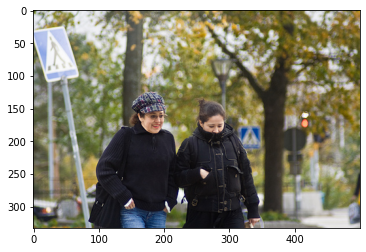

Caption: man in black jacket and cap stands in the street
_____________________________________
Flicker8k_Dataset/2061354254_faa5bd294b.jpg


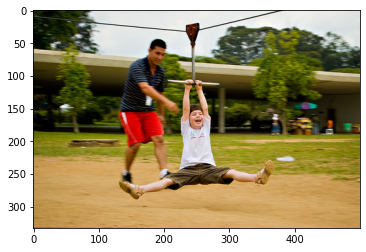

Caption: two men playing soccer on field
_____________________________________
Flicker8k_Dataset/197504190_fd1fc3d4b7.jpg


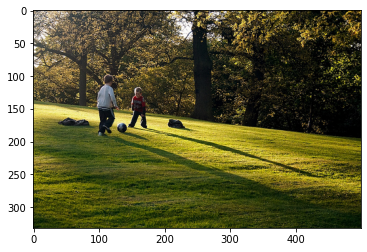

Caption: boy in red shirt is running through the grass
_____________________________________
Flicker8k_Dataset/448658518_eec0b648a6.jpg


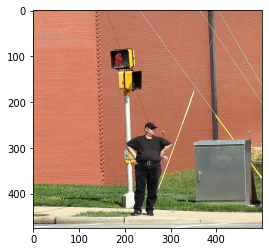

Caption: man in red shirt is standing in front of large display
_____________________________________
Flicker8k_Dataset/370713359_7560808550.jpg


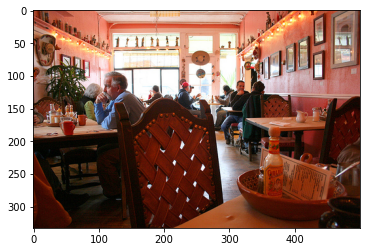

Caption: man in black shirt is standing in front of
_____________________________________
Flicker8k_Dataset/3211556865_d1d9becf69.jpg


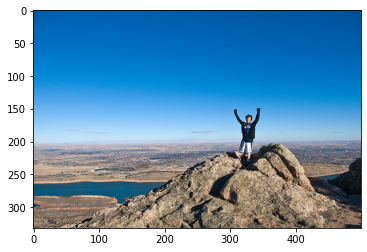

Caption: man is standing on top of cliff overlooking the ocean
_____________________________________
Flicker8k_Dataset/1547883892_e29b3db42e.jpg


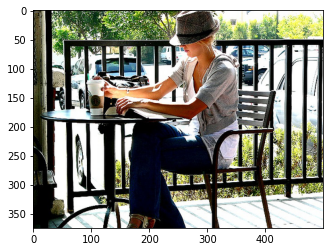

Caption: man in black shirt is sitting on bench under tree
_____________________________________
Flicker8k_Dataset/3537400880_8f410d747d.jpg


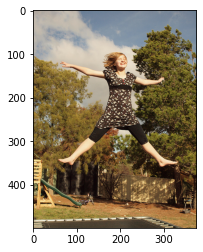

Caption: girl in pink shirt is jumping into the air
_____________________________________
Flicker8k_Dataset/2876993733_cb26107d18.jpg


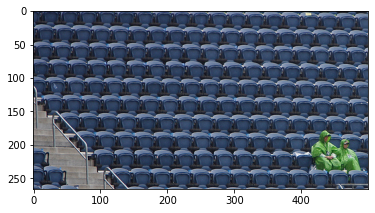

Caption: man in red shirt is skateboarding
_____________________________________
Flicker8k_Dataset/2447284966_d6bbdb4b6e.jpg


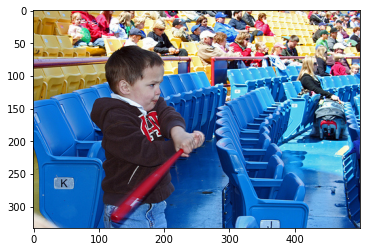

Caption: little boy in blue shirt is playing with racquet
_____________________________________


In [ ]:
for z in range(10):
  pic = list(encoding_test.keys())[z*2]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join('Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join('Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [ ]:
!gdown --id 1-BHpHiKDy9JYJrUaswvbr0prnZZ68GsW

Downloading...
From: https://drive.google.com/uc?id=1-BHpHiKDy9JYJrUaswvbr0prnZZ68GsW
To: /content/captionmod6.h5
19.2MB [00:00, 161MB/s]


In [ ]:
pmodel = load_model('captionmod6.h5')

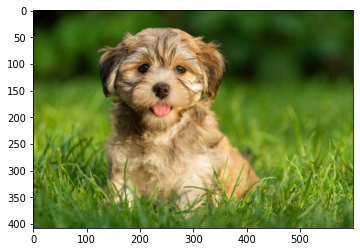

Caption: brown and white dog is running through the grass
_____________________________________


In [ ]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

urls = [
  "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/01/12201051/cute-puppy-body-image.jpg"]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print("Caption:",generateCaption(img,pmodel))
  print("_____________________________________")

In [ ]:
next(data_generator(train_descriptions, encoding_train, wordtoidx, max_length, 1))[0][0][:2]

NameError: ignored

In [ ]:
max_length

34